In [111]:
"""
This notebook creates a Bayesian hierarchy model to estimate the popularity of bike stations based 
on trip data.
"""

import glob
import os

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import pymc as pm
import seaborn as sns

# File name for the final model results
MODEL_RESULTS_FILE = "../models/station_pop_model_results.nc"
STATION_ID_LIST = "../models/station_id_list.pkl"

In [112]:
# Load in the data
df_bike = pd.read_pickle("../data/indego_bike_data.pkl")
print(df_bike.head())

       trip_id  duration           start_time             end_time  \
0  144361832.0      12.0  2017-07-01 00:04:00  2017-07-01 00:16:00   
1  144361829.0      31.0  2017-07-01 00:06:00  2017-07-01 00:37:00   
2  144361830.0      15.0  2017-07-01 00:06:00  2017-07-01 00:21:00   
3  144361831.0      15.0  2017-07-01 00:06:00  2017-07-01 00:21:00   
4  144361828.0      30.0  2017-07-01 00:07:00  2017-07-01 00:37:00   

   start_station  start_lat  start_lon  end_station    end_lat    end_lon  \
0         3160.0  39.956619 -75.198624       3163.0  39.949741 -75.180969   
1         3046.0  39.950119 -75.144722       3101.0  39.942951 -75.159554   
2         3006.0  39.952202  -75.20311       3101.0  39.942951 -75.159554   
3         3006.0  39.952202  -75.20311       3101.0  39.942951 -75.159554   
4         3046.0  39.950119 -75.144722       3101.0  39.942951 -75.159554   

  bike_id  plan_duration trip_route_category passholder_type bike_type  
0   11883           30.0             One Wa

In this notebook, I'm curious to figure out station popularity. I presume that certain stations, or
more specifically, certain routes are much more popular than others.

The first step is to remove any inactive stations from my data, since while I have the whole range
of historical bike ride data, many stations have been added/removed since then. I only want to keep
the most up to date data, so any data with inactive stations will be removed.

In [113]:
# Load station data, including whether or not each station is active
df_stations = pd.read_csv("../data/indego-stations-2025-07-01.csv")

# Keep only station IDs where status is "Active"
active_ids = df_stations.loc[df_stations["Status"] == "Active", "Station_ID"]
print(f"Number of active stations: {len(active_ids)}")
print(f"Active station IDs: {active_ids.tolist()}")

# Keep rides where BOTH start and end stations are active
df_bike_active = df_bike[
    df_bike["start_station"].isin(active_ids) &
    df_bike["end_station"].isin(active_ids)
]

print(df_bike_active.head())

Number of active stations: 272
Active station IDs: [3000.0, 3005.0, 3006.0, 3007.0, 3008.0, 3009.0, 3010.0, 3012.0, 3014.0, 3015.0, 3016.0, 3017.0, 3018.0, 3019.0, 3020.0, 3021.0, 3022.0, 3024.0, 3025.0, 3026.0, 3028.0, 3029.0, 3030.0, 3031.0, 3032.0, 3033.0, 3034.0, 3035.0, 3037.0, 3038.0, 3039.0, 3040.0, 3041.0, 3047.0, 3049.0, 3051.0, 3052.0, 3053.0, 3054.0, 3055.0, 3056.0, 3057.0, 3058.0, 3059.0, 3060.0, 3061.0, 3062.0, 3063.0, 3064.0, 3065.0, 3066.0, 3067.0, 3068.0, 3069.0, 3072.0, 3073.0, 3074.0, 3075.0, 3077.0, 3078.0, 3086.0, 3088.0, 3093.0, 3096.0, 3097.0, 3098.0, 3099.0, 3100.0, 3101.0, 3102.0, 3104.0, 3106.0, 3107.0, 3110.0, 3111.0, 3112.0, 3113.0, 3114.0, 3115.0, 3116.0, 3117.0, 3118.0, 3119.0, 3120.0, 3123.0, 3124.0, 3125.0, 3150.0, 3152.0, 3154.0, 3155.0, 3156.0, 3157.0, 3158.0, 3159.0, 3160.0, 3161.0, 3162.0, 3163.0, 3164.0, 3165.0, 3166.0, 3168.0, 3169.0, 3181.0, 3182.0, 3183.0, 3184.0, 3185.0, 3187.0, 3188.0, 3196.0, 3197.0, 3200.0, 3201.0, 3203.0, 3204.0, 3205.0, 3207

The first major step with figuring out station demand, is to just see how many rides go from one
station to another. This is done with an Origin-Destination matrix, then converting the values to
probabilities to get a first-state transition matrix by normalizing the counts. 

Note that I subset to the busiest top 15 stations, since a visualization with all stations would 
not look good.

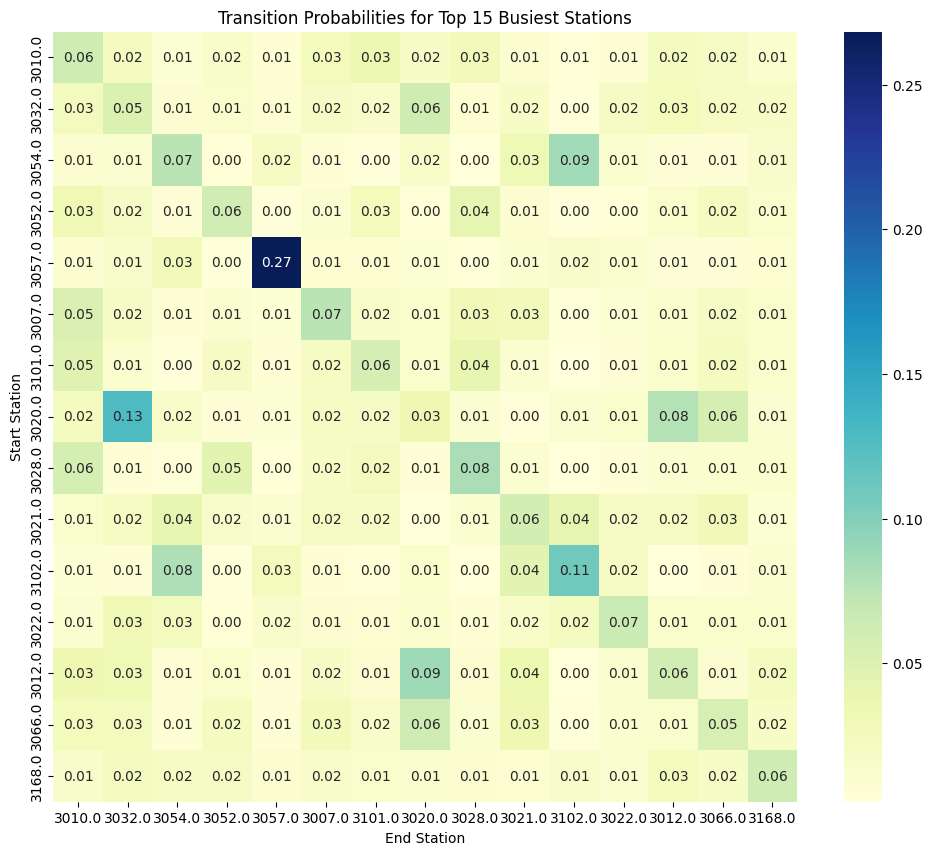

Details for the Top 15 Busiest Stations:
     Station_ID                                Station_Name
4        3007.0                      11th & Pine, Kahn Park
7        3010.0                               15th & Spruce
9        3012.0                            21st & Catharine
17       3020.0                     University City Station
18       3021.0                                  18th & JFK
19       3022.0                  Amtrak 30th Street Station
25       3028.0                            4th & Bainbridge
29       3032.0                                23rd & South
47       3052.0                                9th & Locust
49       3054.0                                Rodin Museum
52       3057.0                  Philadelphia Museum of Art
61       3066.0                              19th & Lombard
82       3101.0                                11th & South
83       3102.0  Pennsylvania & Fairmount Perelman Building
125      3168.0                               20th & Sansom

In [114]:
# Create the overall OD matrix
od_matrix = pd.crosstab(df_bike_active['start_station'], df_bike_active['end_station'])
# Get the transition matrix by normalizing the OD matrix
# This gives the probability of going from one station to another for a single trip
total_departures = od_matrix.sum(axis=1)
transition_matrix = od_matrix.div(total_departures, axis=0).fillna(0)

# Get the top 15 busiest stations based on total traffic, and subset the transition matrix to these
# stations
total_traffic = od_matrix.sum(axis=1) + od_matrix.sum(axis=0)
top_stations = total_traffic.nlargest(15).index.tolist()
transition_matrix_subset = transition_matrix.loc[top_stations, top_stations]

# Plot the transition matrix for the top 15 busiest stations
plt.figure(figsize=(12, 10))
sns.heatmap(
    transition_matrix_subset, 
    annot=True,              
    fmt='.2f',               
    cmap='YlGnBu'             
)
plt.title('Transition Probabilities for Top 15 Busiest Stations')
plt.xlabel('End Station')
plt.ylabel('Start Station')
plt.show()

# Filter df_station to get details for only the top stations
top_stations_details = df_stations[df_stations['Station_ID'].isin(top_stations)]

# Display the resulting DataFrame
print("Details for the Top 15 Busiest Stations:")
print(top_stations_details[["Station_ID", "Station_Name"]])

Note that each row adds up to one, since it represents the probability that a bike starting from one
station, ends up at any other available station.

It is clear that some stations do receive more traffic compared to others. In particular, a lot
of trips end up starting at one bike station, and ending at another. For example, there's a 0.27
probability that a bike ride starting at the Philadelphia Museum of Art, ends there. Also, there is
a 0.13 probability that a ride starting at University City Station ends at 23rd and South (which 
does not sound like a lot, but it is when you consider all the other stations that the rider could
have ended at!).

The issue with this matrix though, is that this includes data for all rides. But, it's likely that 
bike demand changes on the day of the week, and this matrix muddles that together.

----

Instead, I want to build a hierarchical model. This involves looking at the bike paths not just 
local to each station, but also for all stations at the same time. This lets the model learn the 
unique popularity of each station and a set of daily patterns. 

So, the final demand for any given 
station on a specific day of the week is the combination of these two effects (basically letting
the model know that all stations are part of a single bike system). It's even more powerful in that
stations with less rides can borrow "statistical strength", so that the final estimate for unpopular
stations is pulled toward the group average, even if each station is individual.

Note that to ensure more recent data, I subset data to the last two years from when I run the
notebook.

In [115]:
# Subset to the last two years of data
df_bike_active['start_time'] = pd.to_datetime(df_bike_active['start_time'], format="mixed")
cutoff_date = pd.to_datetime('2025-08-16') - pd.DateOffset(years=2)
df_bike_active = df_bike_active[df_bike_active['start_time'] >= cutoff_date].copy()
df_bike_active['day_of_week'] = df_bike_active['start_time'].dt.dayofweek 

# Count trips per station per day
station_counts = df_bike_active.groupby(['start_station', 'day_of_week']).size().reset_index(name='trip_count')

# Create a unique integer index for each station
station_ids = sorted(df_bike_active['start_station'].unique())
station_lookup = {id: i for i, id in enumerate(station_ids)}
station_counts['station_idx'] = station_counts['start_station'].map(station_lookup)

# Prepare data arrays for PyMC
station_idx = station_counts['station_idx'].values
day_of_week_idx = station_counts['day_of_week'].values
trip_counts = station_counts['trip_count'].values

In [ ]:
# Initialize constants for number of unique stations, and number of days in the week
n_stations = len(station_ids)
n_days = 7

# Note that many things are log transformed to ensure that everything is positive
with pm.Model() as station_model:
    # --- Global Priors ---
    # Represents the global average popularity on a log scale across all stations; Normal 
    # distribution chosen since it can have a large range of values and can be positive or negative
    global_log_mu = pm.Normal('global_log_mu', mu=np.log(trip_counts.mean()), sigma=1)
    # Represents the global amount of variation in popularity between stations; Half-Normal since
    # it is a standard choice for variance parameters since it can only be positive
    global_log_sigma = pm.HalfNormal('global_log_sigma', 1.0)

    # --- Station-Level Priors ---
    # Represents the station popularity for every single station, all drawn from the same 
    # distribution (since demand will depend on the demand from other stations); Normal distribution
    # for a safe pick of the distribution
    station_log_popularity = pm.Normal('station_log_popularity', 
                                    mu=global_log_mu, 
                                    sigma=global_log_sigma, 
                                    shape=n_stations)
    
    # --- Day of Week Effects ---
    # This is an array of 7 values, one for each day of week. Represents a positive or negative 
    # adjustment to demand based on the day;
    # Normal distribution is chosen with sigma 0.5 for a "weak" prior without too much impact
    day_effect = pm.Normal('day_effect', mu=0, sigma=0.5, shape=n_days)

    # --- Expected Trip Count Effects ---
    # This is just combining the expected log popularity of a station with the day of the week
    expected_count = pm.math.exp(station_log_popularity[station_idx] + day_effect[day_of_week_idx])

    # --- Likelihood ---
    idata_kwargs = {"log_likelihood": False}
    # Chose the Poisson distribution since the # of trips is non-negative and calculates the
    # probability of observing a certain count, given an average rate mu. This is the main part 
    # where predictions are compared with actual data to ensure the best results
    y_obs = pm.Poisson('y_obs', mu=expected_count, observed=trip_counts)

    # MCMC Sampling
    idata_station = pm.sample(2000, tune=1000, cores=12, progressbar=True, idata_kwargs=idata_kwargs)

# Save the final results to a file for later use
print("\n--- Saving Model Results ---")
# TODO: The model is much larger than previous one; Might need to pickle a smaller file if size
# is an issue later on for streamlit deployment
idata_station.to_netcdf(MODEL_RESULTS_FILE)
print(f"Model results saved to {MODEL_RESULTS_FILE}")

The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details



--- Saving Model Results ---
Model results saved to ../models/station_pop_model_results.nc


In [123]:
# Generate the summary table
summary_df = az.summary(idata_station)
# Print the summary
# NOTE: There seems to be an error when trying to push the notebook with this rendered. But, all the
# statistics look good, so the model should be a good fit and not a poor fit.
# print(summary_df)

Now, I extract the final results of this Bayesian Hierarchical model.

In [119]:
posterior_samples = az.extract(idata_station)

# Access the variables and take the mean across the single 'sample' dimension
station_pop_est = posterior_samples['station_log_popularity'].mean(dim='sample').values
day_effect_est = posterior_samples['day_effect'].mean(dim='sample').values

print("Parameters extracted successfully.")

Parameters extracted successfully.


In [120]:
# Calculate the number of weeks in data
n_weeks = (df_bike_active['start_time'].max() - df_bike_active['start_time'].min()).days / 7
print(f"Dataset spans approximately {n_weeks:.1f} weeks.")

# Extract parameters from model
posterior_samples = az.extract(idata_station)
station_pop_est = posterior_samples['station_log_popularity'].mean(dim='sample').values
day_effect_est = posterior_samples['day_effect'].mean(dim='sample').values

# Make and Normalize Predictions 
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
prediction_df = pd.DataFrame(index=range(n_stations), columns=days)

for station_idx in range(n_stations):
    for day_idx, day_name in enumerate(days):
        log_expected_total_count = station_pop_est[station_idx] + day_effect_est[day_idx]
        expected_total_count = np.exp(log_expected_total_count)
        
        # Normalize to get the daily average 
        avg_daily_demand = expected_total_count / n_weeks
        
        prediction_df.loc[station_idx, day_name] = avg_daily_demand

# Set the DataFrame index to the actual station IDs
prediction_df.index = station_ids
prediction_df.index.name = 'Station_ID'

# Replace the station_id in prediction_df with the actual station name
station_details = df_stations[['Station_ID', 'Station_Name']]
merged_df = pd.merge(prediction_df, station_details, left_index=True, right_on='Station_ID')
merged_df = merged_df.set_index('Station_ID')
# Reorder the columns to have the Station_Name first
cols = ['Station_Name'] + [col for col in merged_df.columns if col != 'Station_Name']
merged_df = merged_df[cols]

print("\nPredicted AVERAGE Daily Demand for Each Station Index:")
print(merged_df.head())

# NOTE: Since I have to do that little trick to remap the index of prediction_df back to the 
# station ids, I need to re-do this trick in later steps when showing the result again. I will
# pickle the result.
with open(STATION_ID_LIST, 'wb') as f:
    pickle.dump(station_ids, f)

Dataset spans approximately 97.7 weeks.

Predicted AVERAGE Daily Demand for Each Station Index:
                         Station_Name        Mon        Tue        Wed  \
Station_ID                                                               
3000.0                Virtual Station   0.221986   0.245432   0.244847   
3005.0              Welcome Park, NPS  13.116616  14.501989  14.467449   
3006.0                  40th & Spruce  15.766096  17.431307  17.389791   
3007.0         11th & Pine, Kahn Park  32.665534   36.11566  36.029642   
3008.0      Temple University Station   7.685162   8.496867    8.47663   

                  Thu        Fri        Sat        Sun  
Station_ID                                              
3000.0       0.246632   0.231762   0.196655   0.182488  
3005.0       14.57294  13.694254  11.619864  10.782795  
3006.0       17.51659  16.460414  13.967009  12.960857  
3007.0      36.292355  34.104081  28.938034  26.853403  
3008.0       8.538438   8.023607     6.8082

Overall, it can be seen that some stations do expect to get a lot more rides than others (at least
over the entire ~2 year period of data). For example, the station at 11th & Pine, Kahn Park gets significantly more traffic - 30+ expected 
rides for every weekday, while other stations don't even pass 20.

What may be alarming though,
is the fact that some stations seem to get less than one daily ride from an expected level. Though,
this is expected. First off, these are likely stations that are in more residential neighborhoods, 
and it shows the power of the hierarchical model. With these low demand stations, the model is 
"borrowing strength" from data from all other stations, so the prediction is slightly above 0, 
instead of being exactly 0.

One particular station to help highlight this is the Virtual Station with ID 3000. This is not
actually a physical station, but more of an admistrative ID used by Indego staff and for things like
special events, so the low demand there is not that surprising.

But, to 
help validate the results, I sum up the total # of rides from all stations for each weekday. 

In [121]:
print(prediction_df.sum())

Mon    3093.524149
Tue    3420.261405
Wed    3412.115229
Thu    3436.994979
Fri    3229.758814
Sat    2740.518644
Sun    2543.097842
dtype: object


This shows that there is a bit more demand overall on weekdays than weekends, which makes sense.
Naturally, commuters will rely on the bikes more often (especially for shorter rides), while people
who ride on bikes during the weekend may be having longer rides. But, this does help highlight 
(with some level of uncertainty removed) that some stations may be better off being removed, or 
perhaps with smaller racks to save money.

To end this notebook, note that this only shows the expected ride demand from starting stations.
This does not include analysis on the demand from end stations, or moreover the demand between any 
two particular stations. Such a model will hopefully be done in a future notebook!